# Script for Fig. 2C NVS et al. (2021)

In [ ]:
import json
import numpy as np
from copy import deepcopy
import matplotlib.pylab as plt
import os
import operator

import sys
sys.path.insert(0, '/Users/natvan/CortexControl.app/Contents/MacOS/teili/')

from teili.tools.visualizer.DataModels.EventsModel import EventsModel
from teili.tools.visualizer.DataControllers import DataController, RasterplotController
from utils_natacha_2 import get_meanfiringrate_from_network_activity,\
                                                        get_network_activity_as_matrix, SpikeEvents

DC = DataController()

In [13]:
freq_to_path_to_rec = {'2': '/Users/natvan/CortexControl_study/rec/Thr_for_PS_generation/142313_2hz.json',  # 143228_2ndtrial_2hz
                       '5': '/Users/natvan/CortexControl_study/rec/1_stim_propagation/112950_prop5hz.json',
                        '10': '/Users/natvan/CortexControl_study/rec/1_stim_propagation/112218_prop10hz.json',
                        '50': '/Users/natvan/CortexControl_study/rec/1_stim_propagation/113209_prop50hz.json',
                        '100':'/Users/natvan/CortexControl_study/rec/1_stim_propagation/113347_prop100hz.json',
                        '200': '/Users/natvan/CortexControl_study/rec/1_stim_propagation/113504_prop200hz.json'}



neuron_ids_col3 = list(range(17, 116+1))
neuron_ids_col3.remove(57)
neuron_ids_col3.remove(61)
neuron_ids_col3.remove(70)
all_active_neuron_ids = {}
for freq in freq_to_path_to_rec.keys():
    all_active_neuron_ids[freq] = neuron_ids_col3
max_neuron_id = np.max(neuron_ids_col3)

network_activity_org = {}
for freq, path_to_recording in freq_to_path_to_rec.items():
    # load recording
    with open(path_to_recording) as f:
        recording = json.load(f)
    # filter for events from Column3 and create SpikeEvent-DataStructure in network_acitivites_org
    network_activity_org[freq] = SpikeEvents(neuron_id=[], ts=[])
    for event_nr, (neuron_id, spike_time) in enumerate(zip(recording['neuron_ids'], recording['spike_times'])):
        if neuron_id in all_active_neuron_ids[freq]:
            network_activity_org[freq].neuron_id.append(neuron_id)
            network_activity_org[freq].ts.append(spike_time*(10**-6))

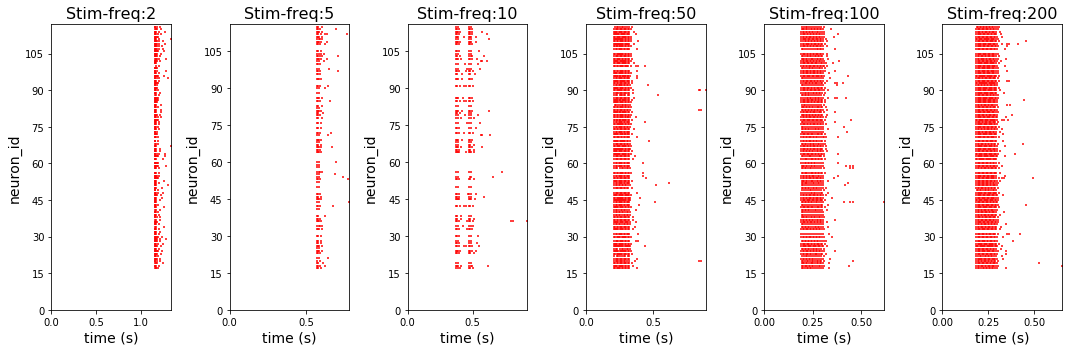

In [14]:
# create rasterplots
fig, (axes) = plt.subplots(ncols=len(freq_to_path_to_rec), nrows=1, figsize=(15,5))
for ax, (freq, events) in zip(axes, network_activity_org.items()):
    eventsmodel  = EventsModel(neuron_ids=events.neuron_id, spike_times=events.ts)
    RasterplotController([eventsmodel], xlabel='time (s)', ylabel='neuron_id', title="Stim-freq:"+freq,
                         mainfig=fig, subfig_rasterplot=ax, show_immediately=False)
plt.tight_layout()

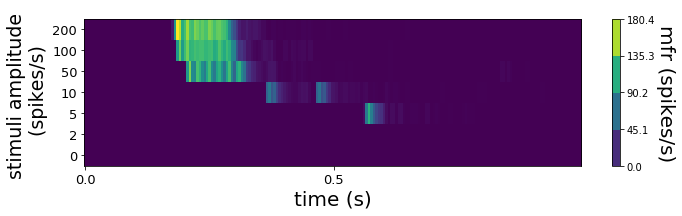

In [20]:
network_activity = deepcopy(network_activity_org)

# filter for time interval & normalize neuron_ids
t_start = 0.  # [s]
t_end   = 1. # [s]
for column_name, column_events in network_activity.items():
    network_activity[column_name].ts, network_activity[column_name].neuron_id = DC.filter_events(all_spike_times=column_events.ts, 
                                                                                         all_neuron_ids=column_events.neuron_id,
                                                                                         interval=(t_start, t_end))
    
# calculate mfr of population
step_size=0.005
window_size=0.01
get_meanfiringrate_from_network_activity(network_activity=network_activity, max_neuron_id=max_neuron_id,
                                         t_start=t_start, t_end=t_end, step_size=step_size, window_size=window_size,
                                         pop_average=True, active_neuron_ids=all_active_neuron_ids)

# create plot
keys_to_row_nr = {'0':6, '2':5, '5':4, '10':3, '50':2, '100':1, '200':0}
network_activity_matrix = get_network_activity_as_matrix(network_activity, keys_to_row_nr=keys_to_row_nr)
mfr_min, mfr_max = np.min(network_activity_matrix), np.max(network_activity_matrix)

fig, (ax) = plt.subplots(nrows=1, figsize=(10,3))
img = ax.imshow(network_activity_matrix, aspect='auto', vmin=mfr_min, vmax=mfr_max)


ax.set_ylabel('stimuli amplitude \n (spikes/s)', fontsize=19 )
ax.set_xlabel('time (s)',  fontsize=20)

time_points = network_activity[list(network_activity.keys())[0]].t_mfr[:,0]
ax.set_xticks(range(0, len(time_points), 100))
ax.set_xticklabels(time_points[::100])

ax.set_yticks(range(0, len(keys_to_row_nr.keys())))
ax.set_yticklabels([i[0] for i in sorted(keys_to_row_nr.items(), key=operator.itemgetter(1))])

plt.xticks(size = 13)
plt.yticks(size = 13)

cbar = plt.colorbar(img, ax=ax, boundaries=np.linspace(mfr_min, mfr_max,5)) 
cbar.set_label('mfr (spikes/s)', rotation=270, size = 20, labelpad= 20
              )
plt.tight_layout()
plt.show()

fig.savefig('Figure_3NVS.pdf')